# 1

In [33]:
"""
Liu et al., "Deep Supervised Hashing for Fast Image Retrieval"
"""
from collections import defaultdict
import random
import torch
from torch import nn
from torch import optim
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from model import LiuDSH

# hyper-parameters
DATA_ROOT = 'data_out'
LR_INIT = 3e-4
BATCH_SIZE = 128
EPOCH = 40
NUM_WORKERS = 8
CODE_SIZE = 8  # bits
MARGIN = 5
ALPHA = 0.01  # TODO: adjust

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_default_dtype(torch.float)

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307, ), std=(0.3081, )),
])


class MNISTPairDataset(Dataset):
    def __init__(self, data_root: str, transform=None, train=True):
        super().__init__()
        self.dataset = MNIST(root=data_root, train=train, transform=transform, download=True)
        self.size = len(self.dataset)

    def __len__(self):
        return self.size

    def __getitem__(self, item):
        # return image pair
        x_img, x_target = self.dataset[item]
        pair_idx = item
        # choose a different index
        while pair_idx == item:
            pair_idx = random.randint(0, self.size - 1)

        y_img, y_target = self.dataset[pair_idx]
        target_equals = 0 if x_target == y_target else 1
        return x_img, x_target, y_img, y_target, target_equals

# 2

In [34]:
train_pair_dataset = MNISTPairDataset(data_root=DATA_ROOT, train=True, transform=mnist_transform)
print(f'Train set size: {len(train_pair_dataset)}')
test_pair_dataset = MNISTPairDataset(data_root=DATA_ROOT, train=False, transform=mnist_transform)
print(f'Test set size: {len(test_pair_dataset)}')

Train set size: 60000
Test set size: 10000


In [35]:
train_pair_dataset[0]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

5 7 1


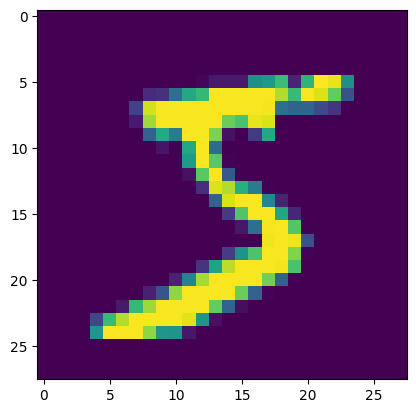

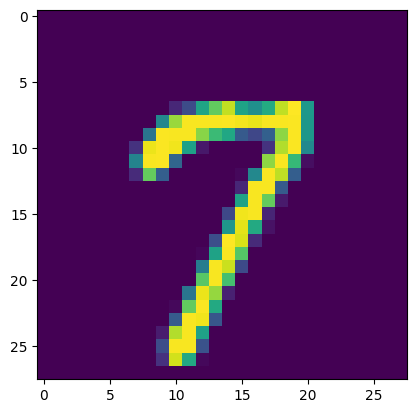

0 7 1


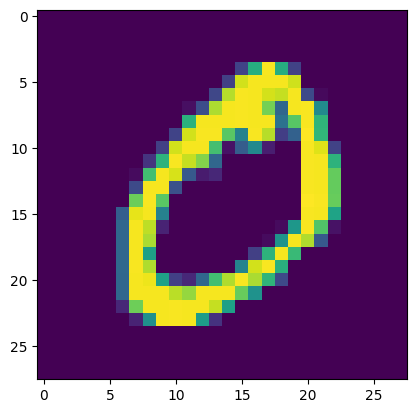

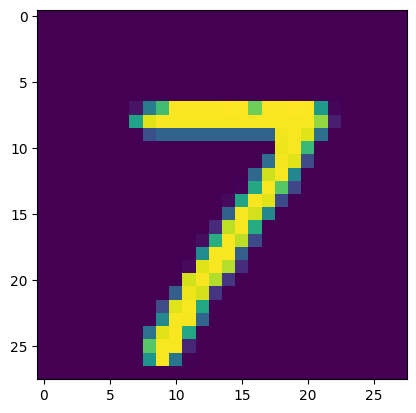

4 9 1


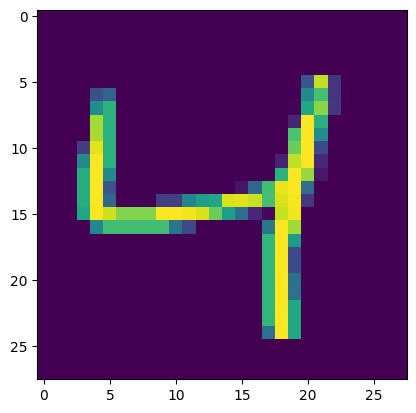

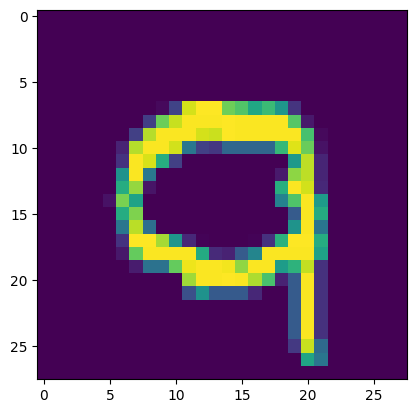

In [36]:
import matplotlib.pyplot as plt

tt = MNIST(root=DATA_ROOT, train=True, transform=mnist_transform, download=True)

# cnt = 0
# for image, l in tt:
#     if cnt == 3:
#         break
#     cnt += 1

#     print(l)

#     plt.imshow(image.permute(1, 2, 0))
#     plt.show()

cnt = 0
for image, x, y, z, t in train_pair_dataset:
    if cnt == 3:
        break
    cnt += 1

    print(x, z, t)

    plt.imshow(image.permute(1, 2, 0))
    plt.show()

    image = y
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    

# 3